# Piecewise Affine Transformation

This example is adapted from [scikit-image](https://scikit-image.org/docs/stable/auto_examples/transform/plot_piecewise_affine.html) and shows how to use the Piecewise Affine Transformation.


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.transform import PiecewiseAffineTransform, warp

We can download the astronaut image from `scikit-image` to learn how a piecewise affine transformation can be applied to a function as well as an image.


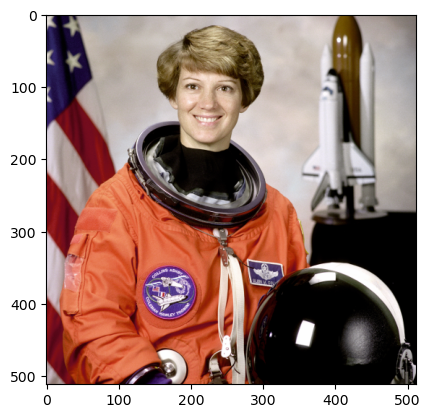

In [22]:
image = np.asarray(data.astronaut())
rows, cols = image.shape[0], image.shape[1]
plt.imshow(image)

It is clear that the image has a structured, regular, and rectilinear grid of pixels. For each x and y coordinate, the image has a corresponding color value (red, green, and blue). In this sense, the image is a function of x and y coordinates and returns an RGB triple. To see this, we can graph a sparser set of x and y values.


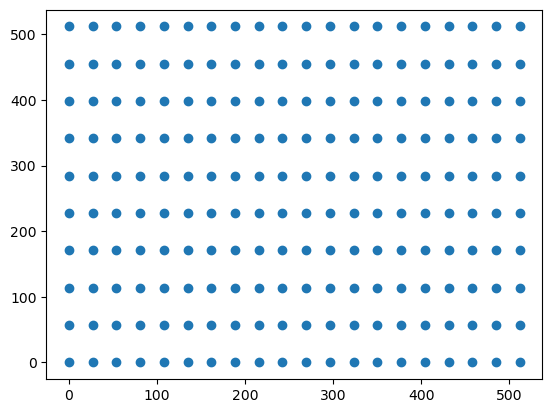

In [23]:
src_cols = np.linspace(0, cols, 20)
src_rows = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flatten(), src_rows.flatten()])[0]
plt.scatter(src_cols, src_rows)

In this example, the coordinates are modified by adding a sinusoidal oscillation to the row coordinates, which result in a wavy effect. We can see this when we plot the modified coordinates.


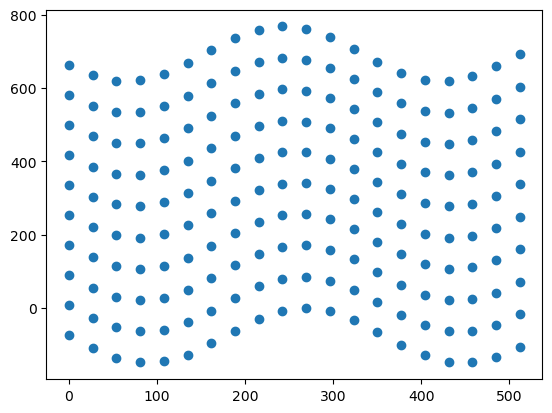

In [24]:
# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
dst_cols = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T
plt.scatter(dst_cols, dst_rows)

Using `PiecewiseAffineTransform` from `scikit-image`, we can estimate the transformation between the original and modified coordinates. Here, we find the best piecewise affine mapping that takes coordinates in the original image (source or src) to coordinates in the modified image (destination or dst).


In [25]:
tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

True

After estimating the transformation for this subset of points, we can apply the transformation to the entire image. This is done by calling `warp` from `scikit-image` and passing the image and the estimated transformation.


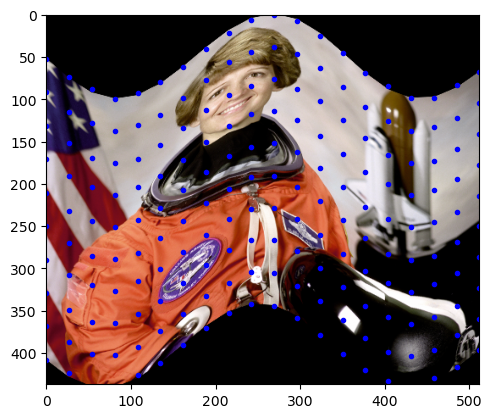

In [26]:
out_rows = image.shape[0] - 1.5 * 50
out_cols = cols
out = warp(image, tform, output_shape=(out_rows, out_cols))

fig, ax = plt.subplots()
ax.imshow(out)
ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], ".b")
ax.axis((0, out_cols, out_rows, 0))
plt.show()

As we can see, the whole image is now transformed to have the same wavy effect as the subset of points. Using this example, we can see how a piecewise affine transformation can be applied to a function.


# Economics Example


For an economics example, we can look at the concept of indiference curves. Indiference curves are iso-utility curves such that any combination of goods on the curve provides the same level of utility. In escence, indifference curves show the trade offs between goods for which the consumer is indiferent. For our example, we'll use the utility function: $u(x,y) = xy$. We can create a contour or indifference curve plot for this function by creating an array of x values, and for a set of fixed utility values, find the y values that satisfy the utility function.


In [27]:
n = 50
m = 50
x_grid = np.linspace(1, 11, n)
y_grid = np.empty(m)

x_mat, y_mat = np.meshgrid(x_grid, y_grid, indexing="ij")
u_mat = np.empty_like(x_mat)

u_mat.shape

(50, 50)

To find the corresponding y values, we can use $y = u/x$.


In [28]:
for i in range(u_mat.shape[1]):
    u_mat[:, i] = (i + 1) * 2
    y_mat[:, i] = u_mat[:, i] / x_mat[:, i]

## Source Data forms a Curvilinear Grid


If we now plot our data, we can see that the points form a curvilinear grid instead of a rectilinear grid. Importantly, our grid is still regular (it is not unstructured or random) and maintains some structured pattern, as we constructed above and can see in the plot below. Points with the same color lie on the same indiference curve and have the same utility level.


(0.0, 100.0)

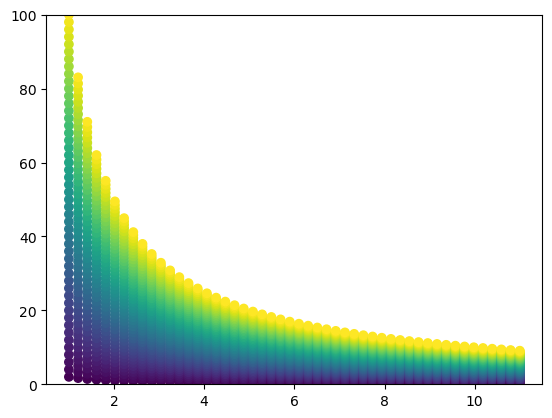

In [29]:
plt.scatter(x_mat, y_mat, c=u_mat)
plt.ylim(0, 100)

Now, let's assume we want to regrid this data into a rectilinear grid. We are interested in the rectangular space $1 \le x \le 10$ and $1 \le y \le 10$. In the plot below, I higlihight the points that lie in this space in blue.


(0.0, 100.0)

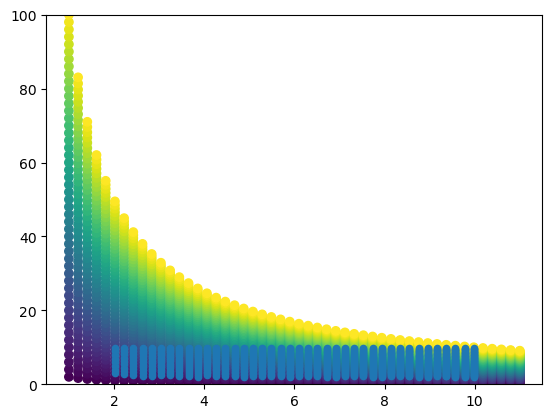

In [30]:
cond = np.logical_and.reduce((x_mat <= 10, y_mat <= 10, x_mat >= 2, y_mat >= 2))
plt.scatter(x_mat, y_mat, c=u_mat)
plt.scatter(x_mat[cond], y_mat[cond], s=20)
plt.ylim(0, 100)

If we "zoom in" on this space, we can clearly see that the points do not lie on a rectangluar grid, making interpolation difficult unless we use an unstructured interpolation method. However, we do not want to use an unstructured interpolation method because we indeed have a structured grid! This is where the piecewise affine transformation comes in.


(2.0, 10.0)

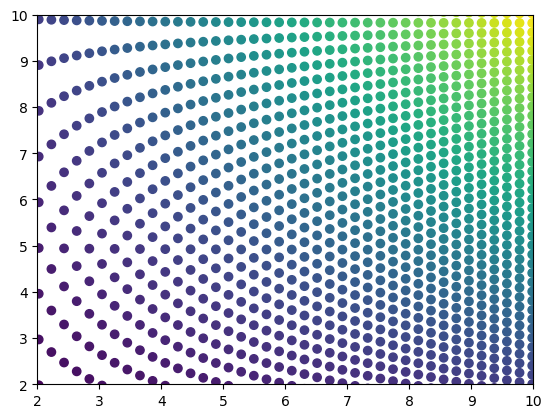

In [31]:
plt.scatter(x_mat, y_mat, c=u_mat)
plt.xlim(2, 10)
plt.ylim(2, 10)

## Destination forms a Rectilinear Grid


Let's imagine that we can stretch and squeeze our source grid to form a rectilinear grid. From the plot above, we can imagine taking the top points on the yellow line and stretching them all the way to the top of the plot, bringing every point below those along for the ride. This is equivalent to converting the $x$ and $y$ values to their respective index coordinates on the grid, which we can accomplish by using `np.mgrid`. On these new, "integerized" coordinates, we can plot the utility values as before. The result is a rectilinear grid of utility values that maps one to one to the curvilinear grid. For illustration, we can also see that the original rectangular space on the curvilinear grid has now been stretched to a triangular space on the rectilinear grid.


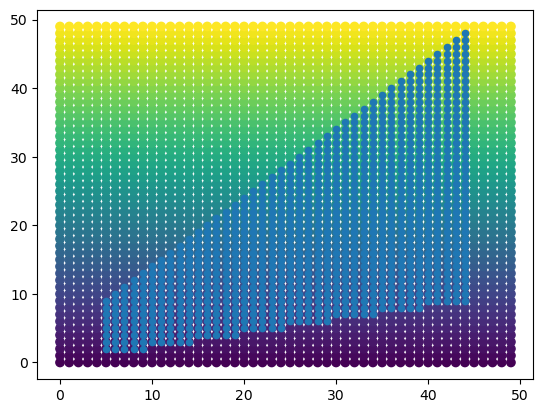

In [32]:
dst_x, dst_y = np.mgrid[0:n, 0:m]
plt.scatter(dst_x, dst_y, c=u_mat)
plt.scatter(
    dst_x[cond],
    dst_y[cond],
    s=20,
)

We can focus on the area of interest by only plotting the points that lie in the rectangular space in the source image, but become a warped triangle in the destination image. We can see that the points in the source image are not on a rectilinear grid, but the points in the destination image are. It is much easier to interpolate on the destination image than the source image, but we need a way to translate the source points onto the destination points.


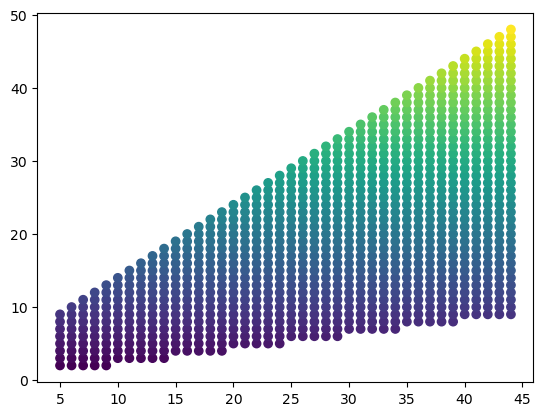

In [33]:
plt.scatter(
    dst_x[cond],
    dst_y[cond],
    c=u_mat[cond],
)

This transformation is exactly what we accomplish by using `scikit-image`'s `PiecewiseAffineTransform`.


In [34]:
# src = np.dstack([x_mat.flat, y_mat.flat])[0]
src = np.vstack([x_mat.flat, y_mat.flat]).T
dst = np.vstack([dst_x.flat, dst_y.flat]).T

tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

True

Below we can see how the estimated transformation maps the source points to the destination points, turning our regular curvilinear grid into a rectangular grid.


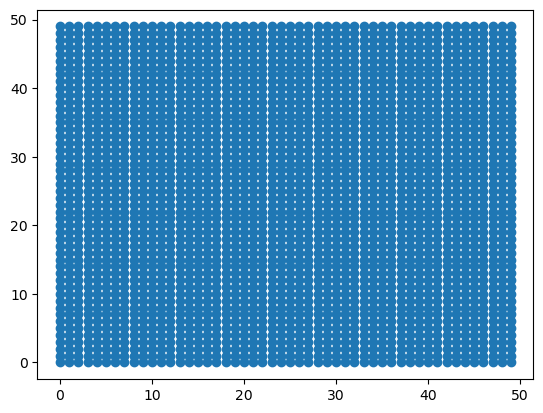

In [35]:
out = tform(src)
x_out, y_out = out[:, 0], out[:, 1]
plt.scatter(x_out, y_out)

Similarly, we can see how the estimated inverse transformation maps the destination points to the source points, turning our regular rectangular grid into a curvilinear grid.


(0.0, 100.0)

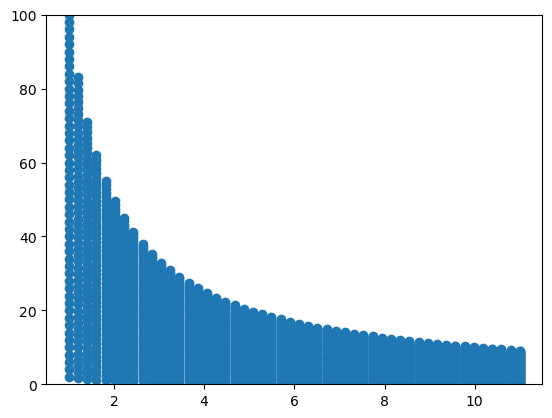

In [36]:
out = tform.inverse(dst)
x_out, y_out = out[:, 0], out[:, 1]
plt.scatter(x_out, y_out)
plt.ylim(0, 100)

# Interpolation using `PiecewiseAffineTransform`

Turning back to our task of interpolating the utility values, we can create a rectilinear grid in the area of interest ($0 \le x \le 10$ and $0 \le y \le 10$).


In [37]:
x_new = np.linspace(2, 10, 100)
y_new = np.linspace(2, 10, 100)

x_new, y_new = np.meshgrid(x_new, y_new, indexing="ij")

We can then use the estimated transformation to map the points in the area of interest from their source coordinates to their destination coordinates. As expected, the points in the area of interest map to a triangle in the destination image, which we saw above.


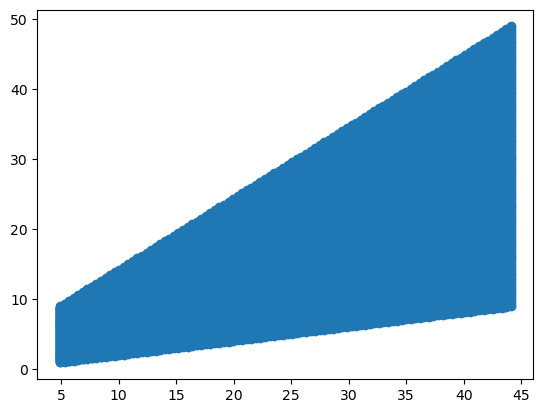

In [38]:
src_new = np.dstack([x_new.flat, y_new.flat])[0]
out = tform(src_new)
x_out = out[:, 0].reshape(x_new.shape)
y_out = out[:, 1].reshape(y_new.shape)


plt.scatter(x_out, y_out)

We can now very easily interpolate the utility values on the destination image, which is a rectilinear grid. For this, we use `scipy`'s `map_coordinates` function, which takes values on a coordinate grid and a set of new coordinates and returns the interpolated values at the new coordinates.


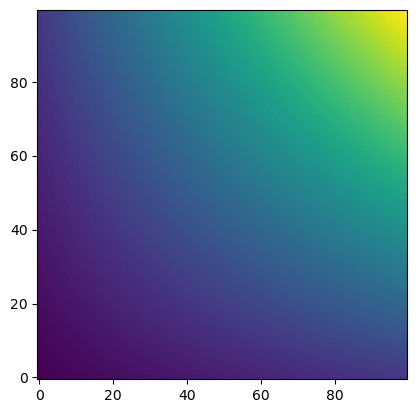

In [39]:
from scipy.ndimage import map_coordinates

u_out = map_coordinates(u_mat, [x_out, y_out], order=1)
plt.imshow(u_out, origin="lower")

# PiecewiseAffineInterp

The `PiecewiseAffineInterp` class is a wrapper around `scikit-image`'s `PiecewiseAffineTransform` and `scipy`'s `map_coordinate` function. It is designed to take a set of source points on a regular curvilinear grid and can be called on any set of query points for interpolation


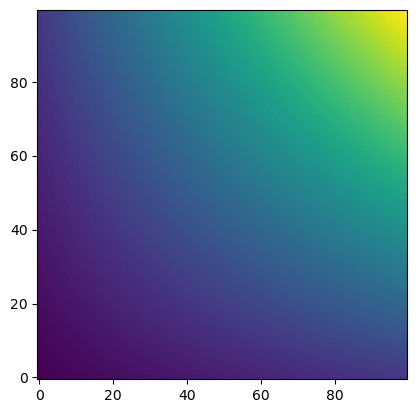

In [40]:
from multinterp import PiecewiseAffineInterp

pa_interp = PiecewiseAffineInterp(u_mat, [x_mat, y_mat])
pa_out = pa_interp(x_new, y_new)
plt.imshow(pa_out, origin="lower")

For comparison, we can see how HARK's `UnstructuredInterp` class performs on the same data.


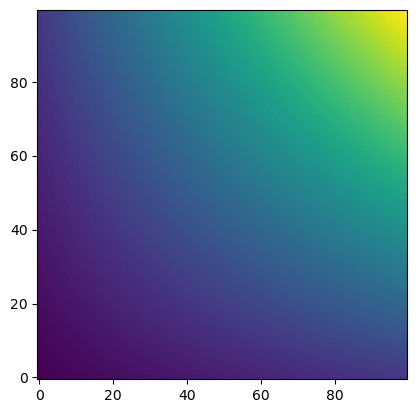

In [41]:
from multinterp import UnstructuredInterp

unstructured_interp = UnstructuredInterp(u_mat, [x_mat, y_mat])
unstruc_out = unstructured_interp(x_new, y_new)
plt.imshow(unstruc_out, origin="lower")

However, as observed, `PiecewiseAffineInterp` is significantly slower than `UnstructuredInterp`.


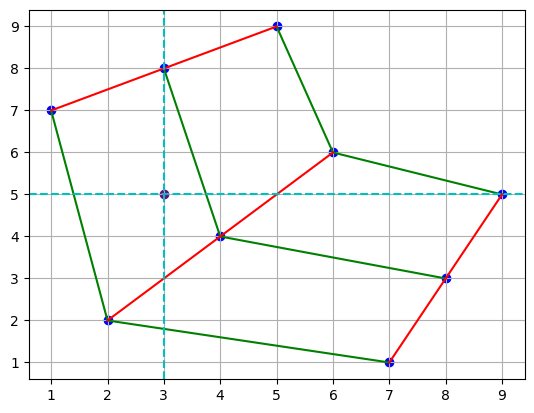

In [42]:
points = np.array(
    [[[1, 7], [3, 8], [5, 9]], [[2, 2], [4, 4], [6, 6]], [[7, 1], [8, 3], [9, 5]]]
).T
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0, 0], points[1, 0], "g")
plt.plot(points[0, 1], points[1, 1], "g")
plt.plot(points[0, 2], points[1, 2], "g")
plt.plot(points[0, :, 0], points[1, :, 0], "r")
plt.plot(points[0, :, 1], points[1, :, 1], "r")
plt.plot(points[0, :, 2], points[1, :, 2], "r")
plt.scatter(3, 5, c="purple")
plt.axhline(y=5, color="c", linestyle="--")
plt.axvline(x=3, color="c", linestyle="--")
plt.grid()

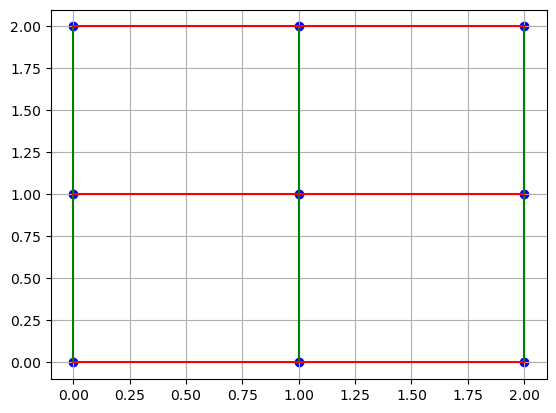

In [43]:
coord_points = np.mgrid[0:3, 0:3]
plt.scatter(coord_points[0], coord_points[1], c="b")
plt.plot(coord_points[0, 0], coord_points[1, 0], "g")
plt.plot(coord_points[0, 1], coord_points[1, 1], "g")
plt.plot(coord_points[0, 2], coord_points[1, 2], "g")
plt.plot(coord_points[0, :, 0], coord_points[1, :, 0], "r")
plt.plot(coord_points[0, :, 1], coord_points[1, :, 1], "r")
plt.plot(coord_points[0, :, 2], coord_points[1, :, 2], "r")
plt.grid()